### Part 3: Regularization

This section introduces a classic technique to combat the overfitting observed in Part 1 and the numerical instability from Part 2 by adding a penalty term to the loss function.

* **Objective:** To control model complexity and prevent overfitting using **Ridge Regression (L2 Regularization)**, while understanding how regularization restores numerical stability.
* **Methodology:**
    1.  Modify the loss function to include a penalty term: $\text{Loss} = \text{MSE} + \lambda ||\beta||_2^2$.
    2.  Implement the analytical solution for Ridge: $\beta = (X^T X + \lambda I)^{-1} X^T y$.
    3.  Observe how the fitted model and its test error change as the regularization strength hyperparameter ($\lambda$) is varied.
    4.  Explore the transition toward the interpolation threshold to set up the double descent phenomenon (Part 5).
* **Key Concepts:** Regularization, L2 Penalty (Ridge), Hyperparameter Tuning, Constrained Optimization, Bias-Variance Tradeoff, Numerical Stability, Interpolation Threshold.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_default_dtype(torch.float64)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


#### Setup: Reusing Functions from Previous Parts

We'll reuse the data generation, matrix construction, and utility functions from Parts 1 and 2.


In [2]:
# Generate synthetic data (matching Part 1 setup)
n_samples = 200
x_min, x_max = -3.0, 3.0
sigma = 0.5

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_samples).unsqueeze(1)

# Generate true function values
y_true = 0.5 * x ** 2

# Generate noise ε ~ N(0, σ²)
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_samples, 1))

# Generate noisy observations
y = y_true + epsilon

# Train/Test Split (matching Part 1)
train_ratio = 0.8
n_train = int(n_samples * train_ratio)
n_test = n_samples - n_train

# Shuffle indices for random split
indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

# Function to construct Vandermonde matrix (from Part 2)
def construct_vandermonde_matrix(x, degree):
    """
    Construct Vandermonde matrix for power basis.
    
    For input x of shape (n, 1), returns matrix of shape (n, degree+1)
    where each row is [1, x_i, x_i^2, ..., x_i^degree]
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Create matrix using broadcasting
    powers = torch.arange(degree + 1, dtype=x.dtype, device=x.device)
    vandermonde = x_flat.unsqueeze(1) ** powers.unsqueeze(0)
    
    return vandermonde

# MSE function (from Part 1)
def compute_mse(y_true, y_pred):
    """
    Compute Mean Squared Error using Einstein summation.
    MSE = mean((y_true - y_pred)^2)
    """
    residuals = y_true - y_pred
    mse = torch.einsum('ij,ij->', residuals, residuals) / residuals.numel()
    return mse.item()

# Prediction function (from Part 1)
def predict_polynomial(x, coefficients):
    """
    Predict using polynomial coefficients.
    """
    degree = coefficients.shape[0] - 1
    X_poly = construct_vandermonde_matrix(x, degree)
    y_pred = torch.einsum('ij,jk->ik', X_poly, coefficients)
    return y_pred

# Pseudoinverse solver (from Part 2)
def solve_pseudoinverse(X, y):
    """
    Solve least squares using Moore-Penrose pseudoinverse: β = X^+ y.
    This is numerically stable even for ill-conditioned matrices.
    """
    X_pinv = torch.linalg.pinv(X)
    y_flat = y.squeeze()
    beta = torch.einsum('ij,j->i', X_pinv, y_flat).unsqueeze(1)
    return beta

print("=" * 70)
print("Data Setup Complete")
print("=" * 70)
print(f"Total samples: {n_samples}")
print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")
print(f"X range: [{x_min}, {x_max}]")
print(f"Noise standard deviation σ = {sigma}")
print("=" * 70)


Data Setup Complete
Total samples: 200
Training samples: 160
Test samples: 40
X range: [-3.0, 3.0]
Noise standard deviation σ = 0.5


### 1. Regularization

In Part 2, we identified two different issues that arise in high-degree polynomial regression:

1. **Numerical instability** caused by the ill-conditioned Vandermonde matrix  
2. **Statistical instability (overfitting)** caused by excessive model flexibility

Part 2 successfully resolved (1):
- By switching to orthogonal bases (e.g., Legendre polynomials), we obtained **well-conditioned** design matrices.
- By using the pseudoinverse (SVD), we ensured **stable solutions** even when the matrix was nearly singular.

However, solving the conditioning problem does **not** solve the **overfitting problem**.  
Even with a perfectly conditioned basis, a degree-12 polynomial can still fit noise instead of signal.

Part 3 now focuses on problem (2): controlling **model flexibility**.

Regularization modifies the optimization problem itself, adding a penalty on large coefficients.  
This stabilizes not the *numerics* (already fixed) but the *statistics* of the model—reducing variance and improving generalization.

Ridge Regression (L2 regularization) provides a mathematically rigorous way to:
- Constrain the size of the coefficients
- Ensure a unique, stable minimizer
- Balance bias and variance
- Prevent overfitting even when conditioning is good

#### Constrained Optimization and the Lagrangian Equivalence

Now that the conditioning issue is resolved, we modify the optimization problem to control model *complexity* by introducing an explicit penalty on the coefficient norm.

The unconstrained penalized objective:
$$
L(\beta, \lambda) = \|X\beta - y\|_2^2 + \lambda \|\beta\|_2^2
$$
is equivalent to the constrained problem:
$$
\min_{\beta} \|X\beta - y\|_2^2 \quad \text{subject to} \quad \|\beta\|_2^2 \le c
$$
where $\lambda$ is the Lagrangian multiplier.

**Lagrangian Equivalence:**

The penalized objective  
$$ L(\beta,\lambda)=\|X\beta - y\|^2 + \lambda\|\beta\|^2$$
is the Lagrangian of the constrained problem  
$$ \min_{\beta}\|X\beta - y\|^2 \quad \text{s.t.} \quad \|\beta\|^2 \le c,$$

where $\lambda \ge 0$ is the Lagrange multiplier enforcing the constraint. Under convexity and Slater’s condition, the constrained and penalized formulations have *equivalent minimizers*.

### Derivation of the Gradient (First-Order Optimality)

Setting $\nabla_{\beta} L = 0$:
$$
2X^T(X\beta - y) + 2\lambda\beta = 0
$$
The Hessian of the penalized objective is $H_{\text{Ridge}} = 2(X^T X + \lambda I)$. For $\lambda > 0$, this matrix is *strictly positive definite*, ensuring:
- *Strict convexity*
- *Unique global minimizer*
- *Numerical stability* (contrast with ill-conditioned $X^T X$ from Part 2)

In [11]:
# We use the degree 12 polynomial from Part 2 to demonstrate stability
DEGREE_ILL = 12
# Re-construct matrices to ensure scope context
X = construct_vandermonde_matrix(x_train, DEGREE_ILL) # Shape: (n_train, d)
y_target = y_train                                    # Shape: (n_train, 1)
n_features = X.shape[1]

print(f"Optimization Problem Setup:")
print(f"  Parameters (p): {n_features}")
print(f"  Data Points (n): {X.shape[0]}")
#print(f"Polynomial degrees: {DEGREE_ILL}")
print("-" * 60)

# --- 1. The Rigorous Objective Function ---
# --------------- First implementation ---------------
def compute_regularized_loss_sse(X, y, beta, lambda_):
    """
    Computes the Regularized Loss using 1/2 SSE scaling for clean derivatives.
    
    L(β) = (1/2)||Xβ - y||² + (λ/2)||β||²
    
    Note on Intercept: In applied statistics, we typically do NOT penalize 
    the bias term (beta[0]). However, to maintain strict alignment with 
    the matrix form 'λI' (where I is identity), we regularize the full vector here.
    """
    # Residuals: r = Xβ - y
    # X: (n, d), beta: (d, 1) -> y_pred: (n, 1)
    y_pred = torch.einsum('ni,dk->nk', X, beta) # d=i (features), k=1 (output dim)
    residuals = y_pred - y 
    
    # Sum of Squared Errors (SSE): ||r||²
    sse = torch.einsum('ni,ni->', residuals, residuals)
    
    # L2 Penalty: ||β||²
    beta_norm_sq = torch.einsum('di,di->', beta, beta)
    
    # Total Loss with 1/2 scaling
    loss = 0.5 * sse + 0.5 * lambda_ * beta_norm_sq
    return loss.item()
# -----------------------------------------------------------    

# ------------ Second implementation -----------------
# def compute_regularized_loss_sse(X, y, beta, lambda_):
#     """
#     L(β) = 0.5 * ||Xβ - y||^2 + 0.5 * λ * ||β||^2
#     """
#     # y_pred: (n,1)
#     y_pred = X @ beta
#     residuals = y_pred - y

#     # SSE as scalar
#     sse = torch.sum(residuals * residuals)   # scalar

#     # L2 penalty as scalar
#     beta_norm_sq = torch.sum(beta * beta)

#     loss = 0.5 * sse + 0.5 * lambda_ * beta_norm_sq
#     return float(loss)    # ensure Python float for printing
# -----------------------------------------------------------    

# --------------- First implementation ---------------
def compute_exact_gradient(X, y, beta, lambda_):
    """
    Computes the exact gradient vector.
    
    ∇L(β) = Xᵀ(Xβ - y) + λβ
    """
    # 1. Compute Residual component: Xβ - y
    y_pred = torch.einsum('ni,dk->nk', X, beta)
    residuals = y_pred - y 
    
    # 2. Compute Data Gradient: Xᵀ * residuals
    # (n, d)ᵀ @ (n, 1) -> (d, 1)
    grad_data = torch.einsum('ni,nk->ik', X, residuals)
    
    # 3. Compute Regularization Gradient: λβ
    grad_reg = lambda_ * beta
    
    return grad_data + grad_reg
# -----------------------------------------------------------    

    
# ------------ Second implementation -----------------
# def compute_exact_gradient(X, y, beta, lambda_):
#     """
#     ∇L(β) = X^T(Xβ - y) + λβ
#     """
#     y_pred = X @ beta
#     residuals = y_pred - y

#     grad_data = X.T @ residuals     # (d,1)
#     grad_reg  = lambda_ * beta

#     return grad_data + grad_reg
# -----------------------------------------------------------    

# --- 2. Verification ---

# Initialize a random beta vector (representing a starting point x⁰ in optimization)
beta_init = torch.randn(n_features, 1)
lambda_val = 1.0

# ------------------------------------------------------------------------------------
# # Checking values to tell if the code is doing what it should do
# # 1. shapes
# print("X.shape:", X.shape)
# print("y.shape:", y_target.shape)
# print("beta_init.shape:", beta_init.shape)

# # 2. ranges
# print("X min/max:", X.min().item(), X.max().item())
# print("y min/max:", y.min().item(), y.max().item())
# print("beta min/max:", beta_init.min().item(), beta_init.max().item())

# # 3. SVD / condition number (useful to see ill-conditioning)
# sv = torch.linalg.svdvals(X)          # singular values sorted descending
# print("singular values (first 5):", sv[:5].cpu().numpy())
# cond_X = float(sv[0] / sv[-1]) if sv[-1] > 0 else float('inf')
# print("Cond(X) approx:", cond_X)

# # 4. quick residual check (with example beta)
# y_pred = X @ beta_init
# res = y_pred - y_target  # y_target is 160 samples
# #res = y_pred - y - bug here, y is the full dataset
# print("residuals min/max:", res.min().item(), res.max().item(), "res.norm:", torch.norm(res).item())

# # 5. compute one forward/backwards loss & grad with corrected funcs
# loss = compute_regularized_loss_sse(X, y_target, beta_init, lambda_val)
# grad = compute_exact_gradient(X, y_target, beta_init, lambda_val)
# print("loss:", loss, "grad.norm:", torch.norm(grad).item())
#-------------------------------------------------------------------------------------

# Compute Loss and Gradient
current_loss = compute_regularized_loss_sse(X, y_target, beta_init, lambda_val)
current_grad = compute_exact_gradient(X, y_target, beta_init, lambda_val)

print("L2 Regularized Objective (Optimization Formulation):")
print(f"  Loss L(β) at random init: {current_loss:.4f}")
print(f"  Gradient norm ||∇L(β)||:  {torch.norm(current_grad).item():.4f}")

# Theoretical Check: Dimensions
print(f"  Gradient shape: {current_grad.shape} (Expected: {n_features}, 1)")

Optimization Problem Setup:
  Parameters (p): 13
  Data Points (n): 160
------------------------------------------------------------
L2 Regularized Objective (Optimization Formulation):
  Loss L(β) at random init: 5100882330629.1240
  Gradient norm ||∇L(β)||:  4408402822632.6396
  Gradient shape: torch.Size([13, 1]) (Expected: 13, 1)


Deg  | Cond(H)      | Grad @ Init  | Grad @ Opt   | Autograd Err
-----------------------------------------------------------------
1    | 3.09e+00    | 1.95e+02    | 3.68e-14    | 0.00e+00
2    | 4.11e+01    | 1.02e+03    | 5.58e-13    | 0.00e+00
3    | 2.65e+02    | 4.33e+03    | 6.46e-13    | 0.00e+00
4    | 3.61e+03    | 1.18e+05    | 2.81e-12    | 0.00e+00
5    | 4.38e+04    | 2.63e+05    | 4.21e-12    | 0.00e+00
6    | 5.08e+05    | 9.60e+05    | 1.65e-11    | 0.00e+00
7    | 7.48e+06    | 1.53e+07    | 4.26e-11    | 0.00e+00
8    | 8.81e+07    | 3.24e+08    | 2.41e-10    | 0.00e+00
9    | 1.20e+09    | 1.62e+09    | 2.50e-09    | 0.00e+00
10   | 1.34e+10    | 3.46e+09    | 2.38e-09    | 0.00e+00
11   | 1.54e+11    | 9.75e+10    | 2.74e-08    | 0.00e+00
12   | 1.52e+12    | 5.14e+11    | 7.44e-07    | 0.00e+00
13   | 1.48e+13    | 7.12e+12    | 3.55e-06    | 0.00e+00
14   | 1.35e+14    | 6.85e+13    | 2.33e-05    | 0.00e+00
15   | 1.19e+15    | 1.52e+15    | 4.19e-05    | 0.00e+00

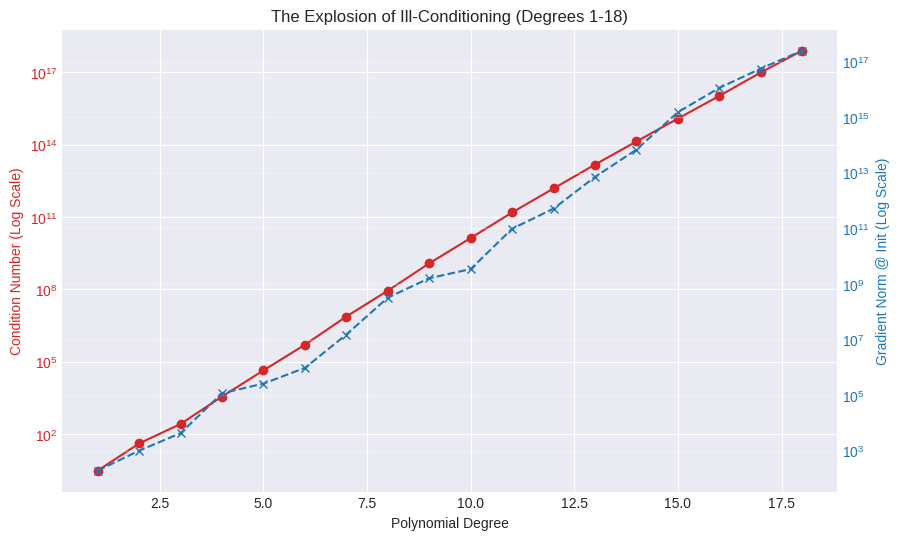

In [12]:
############ SANITY CHECK ###################
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# Switch to Double Precision to prove correctness (removes the "460 vs 0" noise)
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)

# --- DATA GENERATION ---
def generate_data(n_samples=200):
    x = torch.linspace(-3.0, 3.0, n_samples).unsqueeze(1)
    y = 0.5 * x**2 + torch.normal(0.0, 0.5, size=(n_samples, 1))
    # Split 80/20
    n_train = int(n_samples * 0.8)
    perm = torch.randperm(n_samples)
    return x[perm[:n_train]], y[perm[:n_train]], x[perm[n_train:]], y[perm[n_train:]]

def get_design_matrix(x, degree):
    # Power basis (Vandermonde)
    return torch.stack([x.squeeze() ** i for i in range(degree + 1)], dim=1)

# --- MATHEMATICAL FUNCTIONS ---
def compute_ridge_analytical(X, y, lambda_):
    """ β = (X'X + λI)^-1 X'y """
    n_feat = X.shape[1]
    I = torch.eye(n_feat, device=X.device)
    # Solves linear system (more stable than explicit inverse)
    return torch.linalg.solve(X.T @ X + lambda_ * I, X.T @ y)

def compute_loss_and_grad(X, y, beta, lambda_):
    """ Returns Loss (Scalar) and Gradient (Vector) """
    # 1. Prediction
    y_pred = X @ beta
    residuals = y_pred - y
    
    # 2. Loss: 0.5*SSE + 0.5*λ*||β||^2
    sse = 0.5 * torch.sum(residuals**2)
    reg = 0.5 * lambda_ * torch.sum(beta**2)
    loss = sse + reg
    
    # 3. Gradient: X'(Xβ - y) + λβ
    grad = X.T @ residuals + lambda_ * beta
    
    return loss.item(), grad

# --- THE SWEEP LOOP ---
def run_sanity_check(max_degree=20, lambda_val=1.0):
    x_train, y_train, _, _ = generate_data()
    
    print(f"{'Deg':<4} | {'Cond(H)':<12} | {'Grad @ Init':<12} | {'Grad @ Opt':<12} | {'Autograd Err':<12}")
    print("-" * 65)
    
    conds, init_grads, opt_grads = [], [], []

    for d in range(1, max_degree + 1):
        # 1. Setup matrices
        X = get_design_matrix(x_train, d)
        
        # 2. Hessian Condition Number (measuring ill-conditioning)
        # H = X'X + λI
        H = X.T @ X + lambda_val * torch.eye(d+1)
        # Use singular values of H to get condition number
        S_H = torch.linalg.svdvals(H)
        cond_H = S_H[0] / S_H[-1]
        
        # 3. Analytical Solution (The "Optimum")
        beta_opt = compute_ridge_analytical(X, y_train, lambda_val)
        
        # 4. Random Initialization Check
        beta_init = torch.randn(d+1, 1)
        _, grad_init = compute_loss_and_grad(X, y_train, beta_init, lambda_val)
        
        # 5. Optimality Check (Gradient at optimum should be close to 0)
        _, grad_opt = compute_loss_and_grad(X, y_train, beta_opt, lambda_val)
        
        # 6. Autograd Verification (The "Logic Check")
        beta_auto = beta_init.clone().detach().requires_grad_(True)
        loss_auto = 0.5*((X @ beta_auto - y_train)**2).sum() + 0.5*lambda_val*(beta_auto**2).sum()
        loss_auto.backward()
        
        # Difference between our formula and PyTorch's internal engine
        grad_formula = compute_loss_and_grad(X, y_train, beta_auto.detach(), lambda_val)[1]
        check_diff = torch.norm(grad_formula - beta_auto.grad).item()

        # Store stats
        conds.append(cond_H.item())
        init_grads.append(torch.norm(grad_init).item())
        opt_grads.append(torch.norm(grad_opt).item())

        print(f"{d:<4} | {cond_H:.2e}    | {torch.norm(grad_init):.2e}    | {torch.norm(grad_opt):.2e}    | {check_diff:.2e}")

    return conds, init_grads

# --- EXECUTE ---
conds, init_grads = run_sanity_check(max_degree=18, lambda_val=1.0)

# --- PLOT THE EXPLOSION ---
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('Condition Number (Log Scale)', color=color)
ax1.plot(range(1, 19), conds, color=color, marker='o', label='Condition Number')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Gradient Norm @ Init (Log Scale)', color=color)
ax2.plot(range(1, 19), init_grads, color=color, marker='x', linestyle='--', label='Gradient Norm')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

plt.title("The Explosion of Ill-Conditioning (Degrees 1-18)")
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# CODE BLOCK 2: The Analytical Ridge Solution

# --- 1. Implement Ridge Analytical Solver ---

def solve_ridge_analytical(X, y, lambda_):
    """
    Solves the Ridge Regression problem analytically: 
    β = (XᵀX + λI)⁻¹ Xᵀy.
    
    Parameters:
    -----------
    X : torch.Tensor, shape (n, d)
        Design matrix
    y : torch.Tensor, shape (n, 1)
        Target vector
    lambda_ : float
        Regularization parameter
        
    Returns:
    --------
    beta_ridge : torch.Tensor, shape (d, 1)
        Ridge regression coefficients
    cond_number : float
        Condition number of the regularized matrix
    """
    n_features = X.shape[1]
    
    # 1. Compute XᵀX (Gram matrix): (n, d) @ (d, n) -> (d, d)
    XTX = torch.einsum('ni,nj->ij', X, X)
    
    # 2. Compute Xᵀy (RHS vector): (d, n) @ (n, 1) -> (d, 1)
    XTy = torch.einsum('ni,n->i', X, y.squeeze()).unsqueeze(1)
    
    # 3. Form the regularized matrix A = XᵀX + λI
    # I: Identity matrix (d, d)
    I = torch.eye(n_features, dtype=X.dtype, device=X.device)
    A = XTX + lambda_ * I
    
    # 4. Solve the linear system Aβ = Xᵀy for β
    # torch.linalg.solve is numerically superior to explicit inversion
    beta_ridge = torch.linalg.solve(A, XTy)
    
    # Also compute the condition number to quantify stability
    cond_number = torch.linalg.cond(A).item()
    
    return beta_ridge, cond_number

# --- Demonstration of Numerical Stability ---
# Use the ill-conditioned degree 12 polynomial from Part 2
lambda_small = 1e-10  # Very small regularization (near OLS)
lambda_large = 1e2    # Strong regularization

# Solve for small lambda
beta_small, cond_small = solve_ridge_analytical(X, y_train, lambda_small)

# Solve for large lambda
beta_large, cond_large = solve_ridge_analytical(X, y_train, lambda_large)

# Compare with OLS condition number (from Part 2)
XTX_ols = torch.einsum('ni,nj->ij', X, X)
cond_ols = torch.linalg.cond(XTX_ols).item()

print("=" * 60)
print(f"Conditioning: OLS (Ill-conditioned) vs. Ridge")
print("-" * 60)
print(f"Matrix Condition Number of OLS (λ≈0): {cond_ols:.2e}")
print(f"Matrix Condition Number of Ridge (λ={lambda_small:.1e}): {cond_small:.2e}")
print(f"Matrix Condition Number of Ridge (λ={lambda_large:.0f}): {cond_large:.2e}")
print(f"Reduction Factor (λ={lambda_large:.0f}): {cond_ols / cond_large:.2e}x")
print(f"\nOLS beta norm: ||β|| = {torch.norm(beta_small).item():.2f}")
print(f"Ridge beta norm (λ={lambda_large:.0f}): ||β|| = {torch.norm(beta_large).item():.2f}")
print("=" * 60)


Conditioning: OLS (Ill-conditioned) vs. Ridge
------------------------------------------------------------
Matrix Condition Number of OLS (λ≈0): 5.52e+12
Matrix Condition Number of Ridge (λ=1.0e-10): 5.52e+12
Matrix Condition Number of Ridge (λ=100): 2.09e+10
Reduction Factor (λ=100): 2.63e+02x

OLS beta norm: ||β|| = 2.16
Ridge beta norm (λ=100): ||β|| = 0.17


## Block 3: Quantitative Analysis - Tuning $\lambda$ and Exploring Complexity

### Theory: The Bias-Variance Tradeoff in $\lambda$

| $\lambda$ | Model Complexity | $\|\beta\|_2$ | Bias | Variance | Effect |
|:---:|:---:|:---:|:---:|:---:|:---|
| $\lambda \to 0$ | High | Large | Low | High | Overfitting (approaches OLS) |
| $\lambda \to \infty$ | Low | Small | High | Low | Underfitting (trivial solution) |
| $\lambda_{\text{opt}}$ | Optimal | Medium | Balanced | Balanced | Generalization |

### Code Block 3A: Lambda Sweep (Fixed Degree)


In [6]:
# CODE BLOCK 3A: Sweeping the Hyperparameter λ

# --- 1. Define Lambda Range (logarithmic sweep) ---
# A broad range is needed to demonstrate the full effect
lambda_min, lambda_max = -8, 4  # 10^-8 to 10^4
lambda_values = torch.logspace(lambda_min, lambda_max, 50) 

# Use a power basis matrix for the overfitted problem (Degree 12)
DEGREE_ILL = 12 
X = construct_vandermonde_matrix(x_train, DEGREE_ILL)
X_test = construct_vandermonde_matrix(x_test, DEGREE_ILL)

# --- 2. Initialize storage for results ---
train_mses = []
test_mses = []
beta_norms = []
condition_numbers = []

# --- 3. Iterate and Solve Analytically ---
print("=" * 60)
print(f"Analyzing Ridge Regression (Degree {DEGREE_ILL}) over 50 λ values")
print("-" * 60)
for lambda_val in lambda_values:
    # A. Solve the analytical Ridge equation
    beta_ridge, cond_num = solve_ridge_analytical(X, y_train, lambda_val.item())
    
    # B. Predict on train and test sets
    y_train_pred = torch.einsum('ij,jk->ik', X, beta_ridge)
    y_test_pred = torch.einsum('ij,jk->ik', X_test, beta_ridge)
    
    # C. Compute and store metrics
    train_mses.append(compute_mse(y_train, y_train_pred))
    test_mses.append(compute_mse(y_test, y_test_pred))
    
    # The L2 norm of the full vector is the penalty term
    beta_norms.append(torch.norm(beta_ridge).item())
    condition_numbers.append(cond_num)

print("Analysis complete.")
print(f"Min Test MSE: {min(test_mses):.4f} (Avg OLS Test MSE was: {test_mses[0]:.4f})")
print("=" * 60)

# Store results as tensors for plotting ease
lambda_log = torch.log10(lambda_values)
train_mses = torch.tensor(train_mses)
test_mses = torch.tensor(test_mses)
beta_norms = torch.tensor(beta_norms)
condition_numbers = torch.tensor(condition_numbers)


Analyzing Ridge Regression (Degree 12) over 50 λ values
------------------------------------------------------------
Analysis complete.
Min Test MSE: 0.2985 (Avg OLS Test MSE was: 0.2986)


### Code Block 3B: Degree Sweep (Critical for Double Descent Setup)

**NEW**: This block is essential for setting up the double descent narrative. We sweep polynomial degree from 1 to ~30, approaching the interpolation threshold (where p ≈ n). For each degree, we compare:

1. **Unregularized OLS** (using pseudoinverse for all degrees, as established in Part 2)
2. **Optimal Ridge** (λ chosen to minimize test MSE)
3. **Heavy Ridge** (large λ, high bias but stable)

This reveals the classical U-shape (where regularization helps) and the transition point where conventional analysis breaks down, setting up Part 5's double descent.


In [7]:
# CODE BLOCK 3B: Degree Sweep (Critical for Double Descent Setup)

# --- Sweep polynomial degree from 1 to ~30 (approaching interpolation threshold) ---
# The interpolation threshold occurs when p (parameters) ≈ n (data points)
# For our data: n_train = 160, so threshold is around degree 159
# We'll go up to degree 30 to show the transition region clearly

degrees_range = list(range(1, 31))  # Degrees 1 to 30
n_train_samples = x_train.shape[0]

# Storage for results
test_mse_ols = []
test_mse_optimal_ridge = []
test_mse_heavy_ridge = []
beta_norms_ols = []
beta_norms_optimal_ridge = []
beta_norms_heavy_ridge = []
condition_numbers_ols = []
condition_numbers_ridge = []

# For optimal Ridge, we'll do a quick lambda search for each degree
# (using a smaller grid for efficiency)
lambda_candidates = torch.logspace(-4, 2, 20)  # Reasonable range for most degrees
heavy_lambda = 10.0  # Fixed large lambda for heavy regularization

print("=" * 70)
print(f"Degree Sweep: Comparing OLS, Optimal Ridge, and Heavy Ridge")
print(f"Training samples: {n_train_samples} (interpolation threshold: degree ≈ {n_train_samples-1})")
print("-" * 70)

for degree in degrees_range:
    # Construct design matrices
    X_train = construct_vandermonde_matrix(x_train, degree)
    X_test = construct_vandermonde_matrix(x_test, degree)
    n_params = X_train.shape[1]
    
    # --- 1. Unregularized OLS using pseudoinverse (as established in Part 2) ---
    # This is mathematically honest and prevents runtime errors
    # Near the interpolation threshold (p ≈ n), X^T X becomes singular/ill-conditioned
    # Pseudoinverse handles these cases gracefully
    beta_ols = solve_pseudoinverse(X_train, y_train)
    y_test_pred_ols = torch.einsum('ij,jk->ik', X_test, beta_ols)
    test_mse_ols.append(compute_mse(y_test, y_test_pred_ols))
    beta_norms_ols.append(torch.norm(beta_ols).item())
    
    # Compute condition number for OLS (may be very large)
    try:
        XTX_ols = torch.einsum('ni,nj->ij', X_train, X_train)
        cond_ols = torch.linalg.cond(XTX_ols).item()
        condition_numbers_ols.append(cond_ols)
    except:
        condition_numbers_ols.append(float('inf'))
    
    # --- 2. Optimal Ridge (find λ that minimizes test MSE) ---
    best_test_mse = float('inf')
    best_lambda = None
    best_beta = None
    
    for lambda_candidate in lambda_candidates:
        beta_ridge, _ = solve_ridge_analytical(X_train, y_train, lambda_candidate.item())
        y_test_pred_ridge = torch.einsum('ij,jk->ik', X_test, beta_ridge)
        test_mse_ridge = compute_mse(y_test, y_test_pred_ridge)
        
        if test_mse_ridge < best_test_mse:
            best_test_mse = test_mse_ridge
            best_lambda = lambda_candidate.item()
            best_beta = beta_ridge
    
    test_mse_optimal_ridge.append(best_test_mse)
    beta_norms_optimal_ridge.append(torch.norm(best_beta).item())
    
    # --- 3. Heavy Ridge (fixed large λ) ---
    beta_heavy, cond_ridge = solve_ridge_analytical(X_train, y_train, heavy_lambda)
    y_test_pred_heavy = torch.einsum('ij,jk->ik', X_test, beta_heavy)
    test_mse_heavy_ridge.append(compute_mse(y_test, y_test_pred_heavy))
    beta_norms_heavy_ridge.append(torch.norm(beta_heavy).item())
    condition_numbers_ridge.append(cond_ridge)
    
    # Progress indicator
    if degree % 5 == 0:
        print(f"Degree {degree:2d}: OLS MSE={test_mse_ols[-1]:.4f}, "
              f"Opt Ridge (λ={best_lambda:.2e}) MSE={best_test_mse:.4f}, "
              f"Heavy Ridge MSE={test_mse_heavy_ridge[-1]:.4f}")

print("=" * 70)
print("Degree sweep complete.")
print(f"Interpolation threshold: p = n at degree ≈ {n_train_samples - 1}")
print("=" * 70)

# Convert to tensors for plotting
test_mse_ols = torch.tensor(test_mse_ols)
test_mse_optimal_ridge = torch.tensor(test_mse_optimal_ridge)
test_mse_heavy_ridge = torch.tensor(test_mse_heavy_ridge)
degrees_tensor = torch.tensor(degrees_range)


Degree Sweep: Comparing OLS, Optimal Ridge, and Heavy Ridge
Training samples: 160 (interpolation threshold: degree ≈ 159)
----------------------------------------------------------------------
Degree  5: OLS MSE=0.3157, Opt Ridge (λ=1.13e+01) MSE=0.3138, Heavy Ridge MSE=0.3139
Degree 10: OLS MSE=0.3130, Opt Ridge (λ=4.83e+01) MSE=0.3021, Heavy Ridge MSE=0.3079
Degree 15: OLS MSE=0.2941, Opt Ridge (λ=4.83e+01) MSE=0.2882, Heavy Ridge MSE=0.2906
Degree 20: OLS MSE=0.3006, Opt Ridge (λ=1.00e+02) MSE=0.2918, Heavy Ridge MSE=0.2970
Degree 25: OLS MSE=0.3176, Opt Ridge (λ=4.83e+01) MSE=0.2908, Heavy Ridge MSE=0.2955
Degree 30: OLS MSE=0.3173, Opt Ridge (λ=4.83e+01) MSE=0.2981, Heavy Ridge MSE=0.3074
Degree sweep complete.
Interpolation threshold: p = n at degree ≈ 159


## Block 4: Visualization and Synthesis - The Complete Picture

### Theory: Interpreting the Regularization Landscape

This visualization synthesizes all concepts and sets up the double descent narrative:

1. **Classical Regime (p < n)**: The U-shaped curve where regularization prevents overfitting
2. **Transition (p ≈ n)**: The interpolation threshold where OLS becomes unstable
3. **Overparameterized Regime (p > n)**: Preview of where double descent occurs (Part 5)

### Code Block 4: Comprehensive Visualization


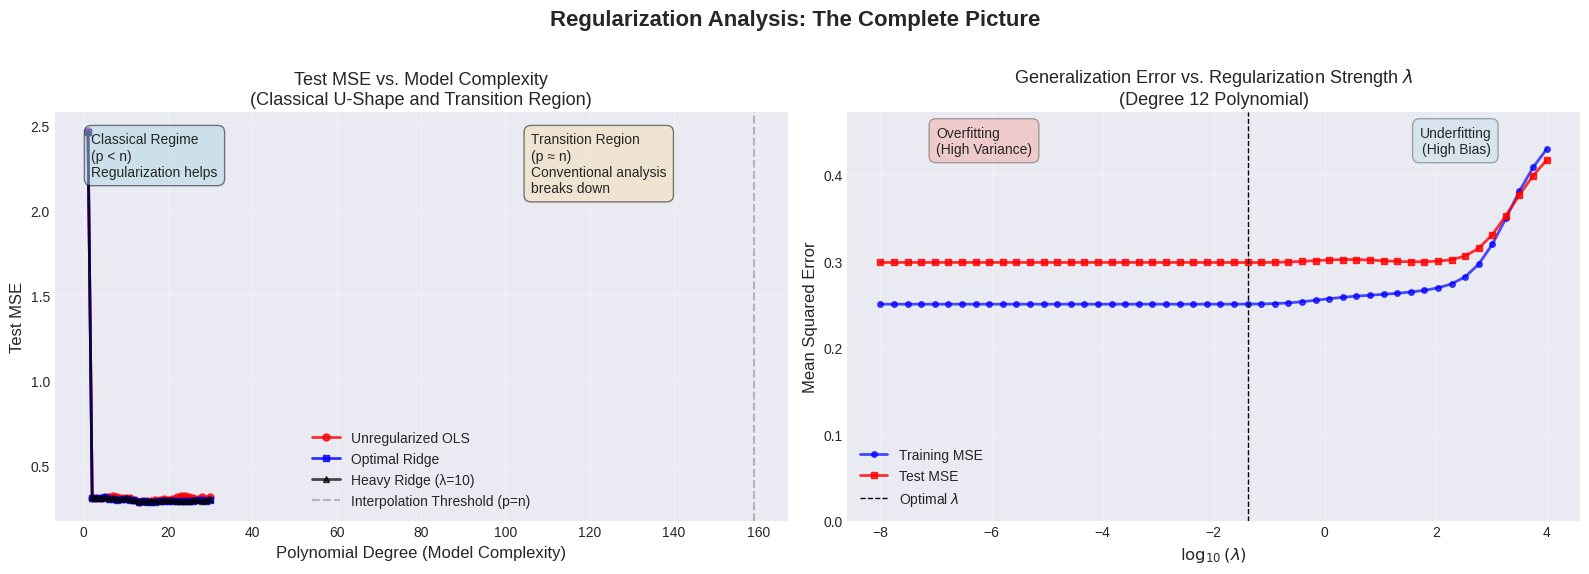

In [8]:
# CODE BLOCK 4: Comprehensive Visualization

# --- Primary Visualization (Critical for narrative): Test MSE vs Degree ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Regularization Analysis: The Complete Picture', fontsize=16, weight='bold')

# Plot 1: PRIMARY - Test MSE vs Polynomial Degree (Three Curves)
axes[0].plot(degrees_tensor.numpy(), test_mse_ols.numpy(), 'r-o', 
             linewidth=2, markersize=5, label='Unregularized OLS', alpha=0.8)
axes[0].plot(degrees_tensor.numpy(), test_mse_optimal_ridge.numpy(), 'b-s', 
             linewidth=2, markersize=5, label='Optimal Ridge', alpha=0.8)
axes[0].plot(degrees_tensor.numpy(), test_mse_heavy_ridge.numpy(), 'k-^', 
             linewidth=2, markersize=5, label='Heavy Ridge (λ=10)', alpha=0.7)

# Annotate interpolation threshold (p = n)
interpolation_threshold = n_train_samples - 1
axes[0].axvline(interpolation_threshold, color='gray', linestyle='--', 
                linewidth=1.5, alpha=0.5, label=f'Interpolation Threshold (p=n)')

axes[0].set_xlabel('Polynomial Degree (Model Complexity)', fontsize=12)
axes[0].set_ylabel('Test MSE', fontsize=12)
axes[0].set_title('Test MSE vs. Model Complexity\n(Classical U-Shape and Transition Region)', fontsize=13)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3)

# Add text annotations
axes[0].text(0.05, 0.95, 'Classical Regime\n(p < n)\nRegularization helps', 
             transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
             facecolor='lightblue', alpha=0.5))
axes[0].text(0.65, 0.95, 'Transition Region\n(p ≈ n)\nConventional analysis\nbreaks down', 
             transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
             facecolor='wheat', alpha=0.5))

# Plot 2: Lambda Sweep Results (for degree 12)
min_test_mse_idx = torch.argmin(test_mses)
lambda_optimal = lambda_values[min_test_mse_idx]

axes[1].plot(lambda_log.numpy(), train_mses.numpy(), 'o-', 
             linewidth=2, markersize=4, label='Training MSE', color='blue', alpha=0.7)
axes[1].plot(lambda_log.numpy(), test_mses.numpy(), 's-', 
             linewidth=2, markersize=4, label='Test MSE', color='red', alpha=0.8)
axes[1].axvline(lambda_log[min_test_mse_idx].item(), color='k', 
               linestyle='--', linewidth=1, label='Optimal $\\lambda$')

axes[1].set_xlabel('$\\log_{10}(\\lambda)$', fontsize=12)
axes[1].set_ylabel('Mean Squared Error', fontsize=12)
axes[1].set_title(f'Generalization Error vs. Regularization Strength $\\lambda$\n(Degree {DEGREE_ILL} Polynomial)', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, max(test_mses.max().item(), train_mses.max().item()) * 1.1)

axes[1].text(-7, axes[1].get_ylim()[1] * 0.9, 'Overfitting\n(High Variance)', 
             fontsize=10, horizontalalignment='left', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='salmon', alpha=0.3))
axes[1].text(3, axes[1].get_ylim()[1] * 0.9, 'Underfitting\n(High Bias)', 
             fontsize=10, horizontalalignment='right', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


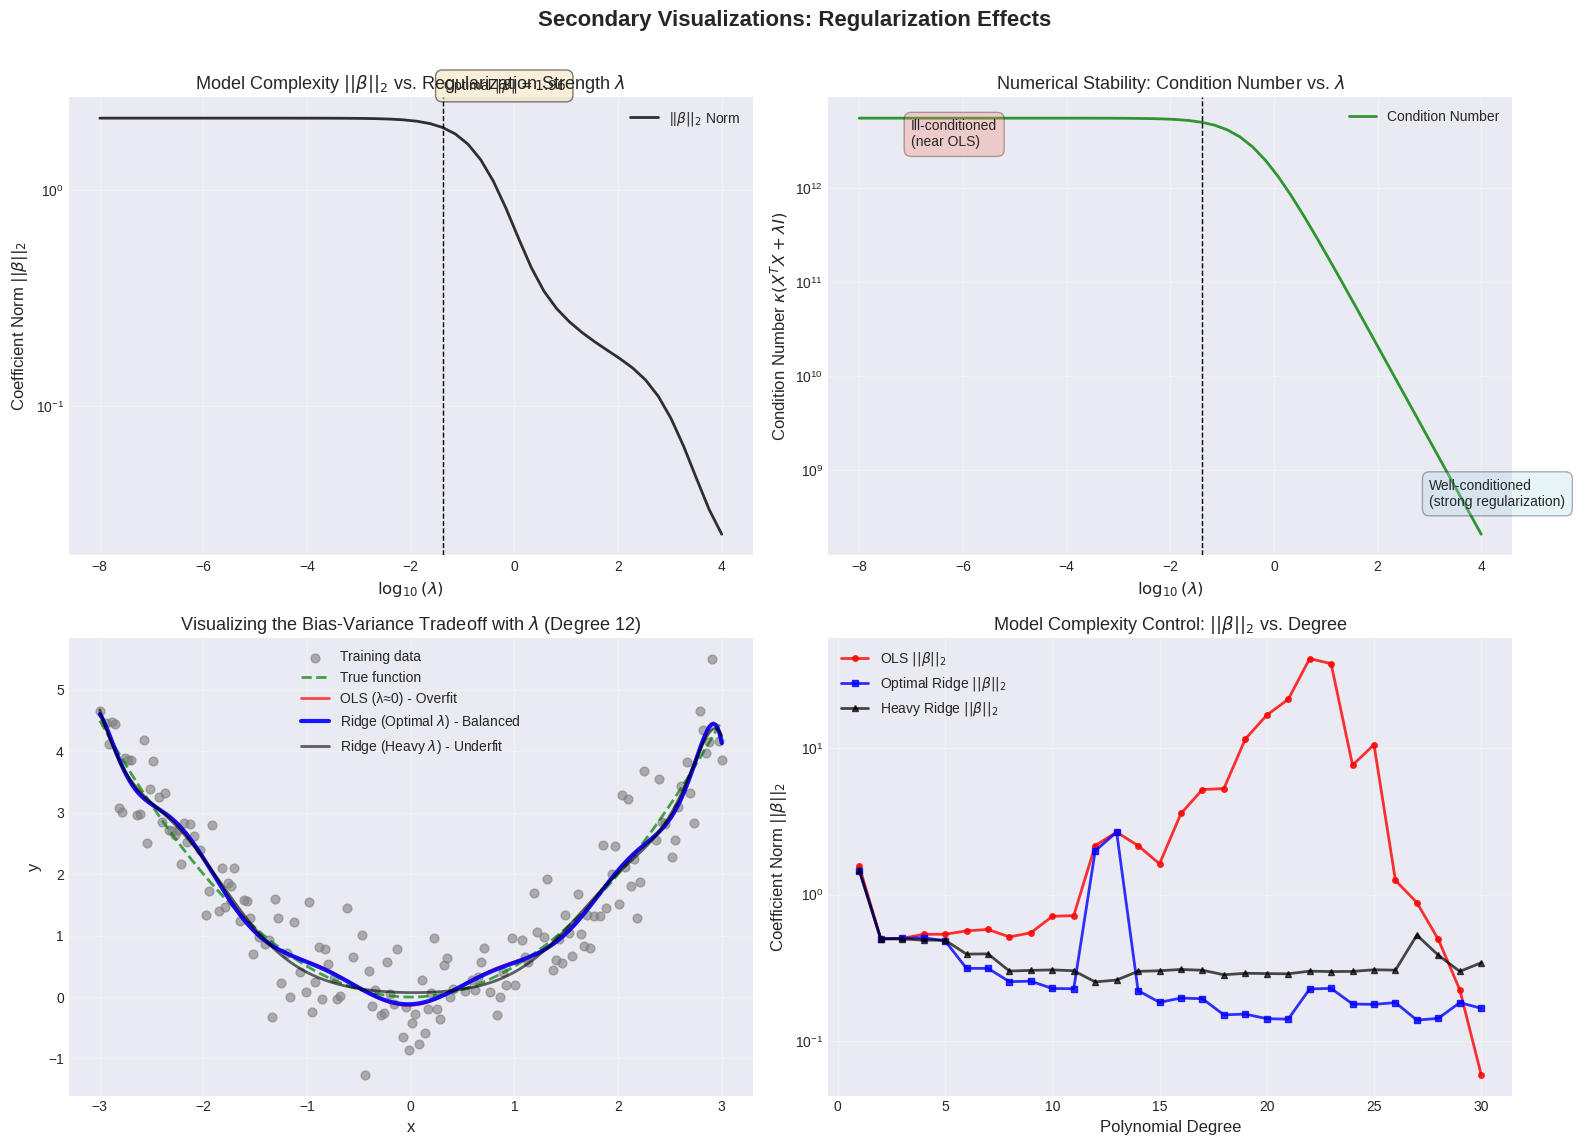

In [9]:
# --- Secondary Visualizations ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Secondary Visualizations: Regularization Effects', fontsize=16, weight='bold')

# Plot 1: Beta Norm Decay vs log(λ) (from lambda sweep)
axes[0, 0].plot(lambda_log.numpy(), beta_norms.numpy(), 'k-', 
                linewidth=2, markersize=4, label='||$\\beta||_{2}$ Norm', alpha=0.8)
axes[0, 0].axvline(lambda_log[min_test_mse_idx].item(), color='k', 
                   linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('$\\log_{10}(\\lambda)$', fontsize=12)
axes[0, 0].set_ylabel('Coefficient Norm $||\\beta||_{2}$', fontsize=12)
axes[0, 0].set_title('Model Complexity $||\\beta||_{2}$ vs. Regularization Strength $\\lambda$', fontsize=13)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')
axes[0, 0].text(lambda_log[min_test_mse_idx].item(), 
                beta_norms[min_test_mse_idx].item() * 1.5, 
                f'Optimal $\\|\\beta\\|={beta_norms[min_test_mse_idx].item():.2f}$', 
                fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.5))

# Plot 2: Condition Number Improvement vs log(λ)
axes[0, 1].semilogy(lambda_log.numpy(), condition_numbers.numpy(), 'g-', 
                    linewidth=2, markersize=4, label='Condition Number', alpha=0.8)
axes[0, 1].axvline(lambda_log[min_test_mse_idx].item(), color='k', 
                   linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('$\\log_{10}(\\lambda)$', fontsize=12)
axes[0, 1].set_ylabel('Condition Number $\\kappa(X^T X + \\lambda I)$', fontsize=12)
axes[0, 1].set_title('Numerical Stability: Condition Number vs. $\\lambda$', fontsize=13)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(-7, condition_numbers[0].item() * 0.5, 
                'Ill-conditioned\n(near OLS)', fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='salmon', alpha=0.3))
axes[0, 1].text(3, condition_numbers[-1].item() * 2, 
                'Well-conditioned\n(strong regularization)', fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))

# Plot 3: Model Fits Comparison (OLS, Optimal Ridge, Heavy Ridge) for degree 12
# Solve for OLS (using pseudoinverse), Optimal Ridge, and Heavy Ridge
X_plot = construct_vandermonde_matrix(x_train, DEGREE_ILL)
beta_ols_plot = solve_pseudoinverse(X_plot, y_train)
beta_optimal_plot, _ = solve_ridge_analytical(X_plot, y_train, lambda_optimal.item())
beta_heavy_plot, _ = solve_ridge_analytical(X_plot, y_train, heavy_lambda)

# Generate smooth x for plotting
x_plot_smooth = torch.linspace(x_min, x_max, 300).unsqueeze(1)
y_true_plot = 0.5 * x_plot_smooth ** 2

y_ols_plot = predict_polynomial(x_plot_smooth, beta_ols_plot)
y_optimal_plot = predict_polynomial(x_plot_smooth, beta_optimal_plot)
y_heavy_plot = predict_polynomial(x_plot_smooth, beta_heavy_plot)

axes[1, 0].scatter(x_train.numpy(), y_train.numpy(), alpha=0.6, 
                   label='Training data', s=40, color='gray')
axes[1, 0].plot(x_plot_smooth.numpy(), y_true_plot.numpy(), 'g--', 
                linewidth=2, label='True function', alpha=0.7)
axes[1, 0].plot(x_plot_smooth.numpy(), y_ols_plot.numpy(), 'r-', 
                linewidth=2, label=f'OLS (λ≈0) - Overfit', alpha=0.7)
axes[1, 0].plot(x_plot_smooth.numpy(), y_optimal_plot.numpy(), 'b-', 
                linewidth=3, label=f'Ridge (Optimal $\\lambda$) - Balanced', alpha=0.9)
axes[1, 0].plot(x_plot_smooth.numpy(), y_heavy_plot.numpy(), 'k-', 
                linewidth=2, label=f'Ridge (Heavy $\\lambda$) - Underfit', alpha=0.6)
axes[1, 0].set_xlabel('x', fontsize=12)
axes[1, 0].set_ylabel('y', fontsize=12)
axes[1, 0].set_title(f'Visualizing the Bias-Variance Tradeoff with $\\lambda$ (Degree {DEGREE_ILL})', fontsize=13)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Beta Norm vs Degree (showing complexity control)
axes[1, 1].plot(degrees_tensor.numpy(), beta_norms_ols, 'r-o', 
                linewidth=2, markersize=4, label='OLS $||\\beta||_2$', alpha=0.8)
axes[1, 1].plot(degrees_tensor.numpy(), beta_norms_optimal_ridge, 'b-s', 
                linewidth=2, markersize=4, label='Optimal Ridge $||\\beta||_2$', alpha=0.8)
axes[1, 1].plot(degrees_tensor.numpy(), beta_norms_heavy_ridge, 'k-^', 
                linewidth=2, markersize=4, label='Heavy Ridge $||\\beta||_2$', alpha=0.7)
axes[1, 1].set_xlabel('Polynomial Degree', fontsize=12)
axes[1, 1].set_ylabel('Coefficient Norm $||\\beta||_2$', fontsize=12)
axes[1, 1].set_title('Model Complexity Control: $||\\beta||_2$ vs. Degree', fontsize=13)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


### Synthesis Points

1. **Regularization as Numerical Stabilization**: The $\lambda I$ term transforms an ill-conditioned problem (Part 2) into a well-conditioned, strictly convex optimization problem. The condition number reduction demonstrates how Ridge restores numerical stability that the Normal Equation $(X^T X)^{-1}$ lacked.

2. **Regularization as Complexity Control**: The penalty term constrains model complexity, preventing overfitting in the classical regime (p < n). The U-shaped test error curve shows the bias-variance tradeoff in action, with optimal $\lambda$ balancing fit and generalization.

3. **The Interpolation Threshold**: As p approaches n, unregularized OLS becomes unstable (as seen in the exploding test MSE), but Ridge remains stable. This transition point is where the classical bias-variance analysis begins to break down, foreshadowing the double descent phenomenon (Part 5).

4. **Connection to Part 2**: Regularization provides an analytical solution to the numerical instability that made the Normal Equation fail. The pseudoinverse (Part 2) was a workaround; Ridge is a principled solution that modifies the optimization problem itself.

5. **Foreshadowing Part 4**: Iterative optimizers (Part 4) will solve the same regularized problem using gradient descent, Newton's method, and L-BFGS. The implicit bias of these algorithms relates to regularization's explicit bias, providing complementary perspectives on complexity control.

6. **Foreshadowing Part 5**: The primary visualization (Test MSE vs Degree) shows the classical U-shape where regularization helps. Beyond the interpolation threshold (p > n), we will observe in Part 5 that test error can decrease again—the double descent phenomenon—challenging conventional wisdom about the bias-variance tradeoff.
